In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../spx_w/eoy_chains.csv')

In [48]:
quote_date = '2023-02-02'
df_expiry = df[(df['quote'] == quote_date) & (df['option_type'] == 'c')].copy().sort_values('strike')
df_expiry['midprice'] = (df_expiry['Bid'] + df_expiry['Ask']) / 2

# remove nan midprices and vols
df_expiry = df_expiry[~np.isnan(df_expiry['midprice'])]
df_expiry = df_expiry[~np.isnan(df_expiry['Implied Volatility'])]

# remove strikes over $2000 under from underlying
#df_expiry = df_expiry[df_expiry['underlying'] - df_expiry['strike'] < 2000]

## Getting RND using Call Prices

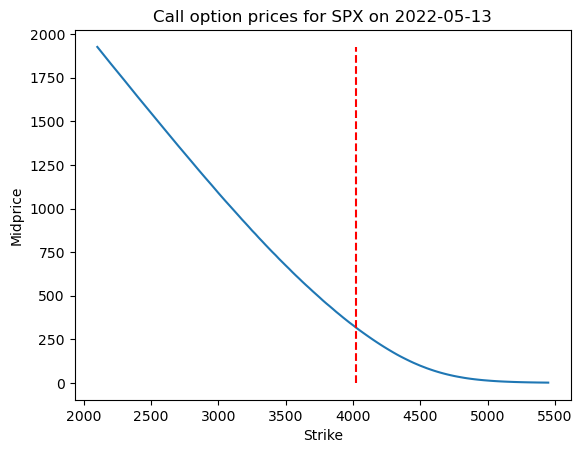

In [31]:
strikes = df_expiry['strike'].values
call_prices = df_expiry['midprice'].values
S0 = df_expiry['underlying'].values[0]

strike_min = strikes.min()
strike_max = strikes.max()
strike_range = np.linspace(strike_min, strike_max, 2000)

# plot
plt.plot(strikes, call_prices)
plt.vlines(S0, 0, max(call_prices), colors='r', linestyles='dashed')
plt.xlabel('Strike')
plt.ylabel('Midprice')
plt.title(f'Call option prices for SPX on {quote_date}')
plt.show()

### Univariate Spline

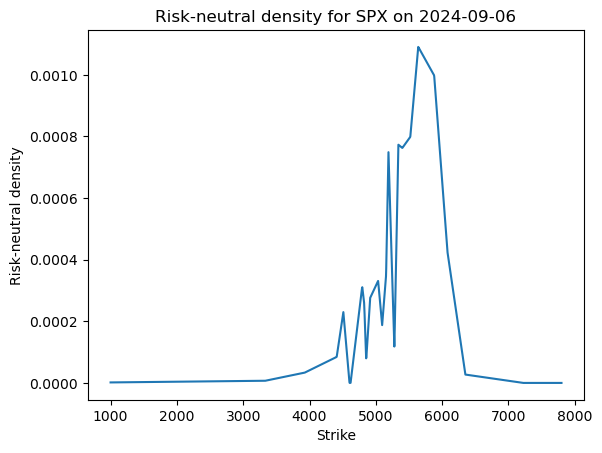

In [6]:
from scipy.interpolate import UnivariateSpline

# fit spline
smoothing = 15
uni_spline = UnivariateSpline(strikes, call_prices, k=3, s=smoothing)

# calc RND
uni_density = uni_spline.derivative(n=2)(strike_range)
uni_density = np.maximum(uni_density, 0)
uni_area = np.trapz(uni_density, strike_range)
uni_density_normalized = uni_density / uni_area

# plot
plt.plot(strike_range, uni_density_normalized)
plt.xlabel('Strike')
plt.ylabel('Risk-neutral density')
plt.title(f'Risk-neutral density for SPX on {quote_date}')
plt.show()

### LSQUnivariateSpline

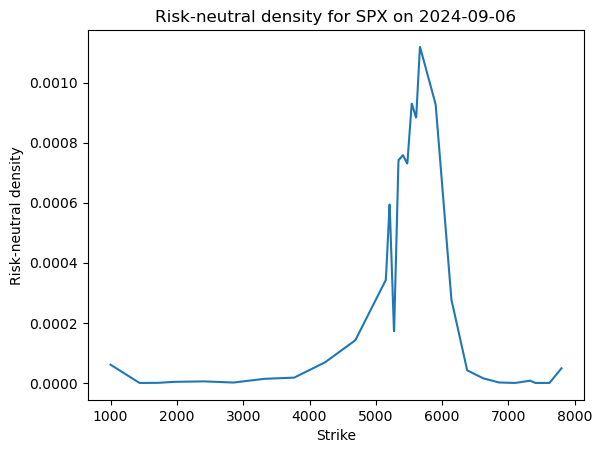

In [7]:
# using LSQUnivariateSpline
from scipy.interpolate import LSQUnivariateSpline

# more knots around S0, fewer as we go away
space = 200
inner_x = 7
offset = space + (space*2)/inner_x
inner = np.linspace(S0 - space, S0 + space, inner_x)
outer = np.concatenate([np.linspace(strikes.min(), S0 - offset, 10),
                        np.linspace(S0 + offset, strikes.max(), 10)])

knots = np.sort(np.concatenate([outer, inner]))
knots = knots[(knots > strikes.min()) & (knots < strikes.max())]

# fit spline
lsq_spline = LSQUnivariateSpline(strikes, call_prices, knots)

# calculate RND with univariate spline
lsq_density = lsq_spline.derivative(n=2)(strike_range)
lsq_density = np.maximum(lsq_density, 0)
lsq_area = np.trapz(lsq_density, strike_range)
lsq_density_normalized = lsq_density / lsq_area

# plot
plt.plot(strike_range, lsq_density_normalized)
plt.xlabel('Strike')
plt.ylabel('Risk-neutral density')
plt.title(f'Risk-neutral density for SPX on {quote_date}')
plt.show()

## RND with Implied Vol

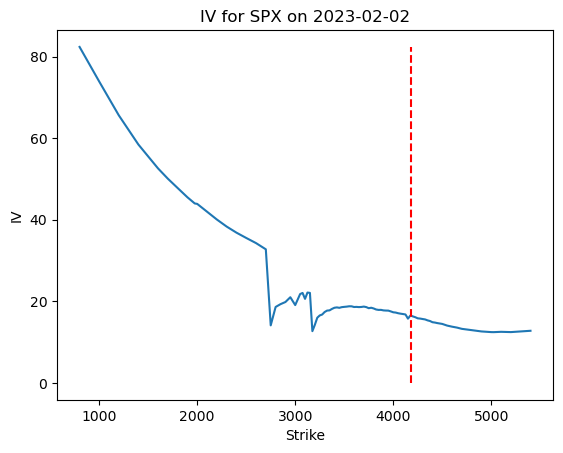

In [49]:
strikes = df_expiry['strike'].values
iv = df_expiry['Implied Volatility'].values
S0 = df_expiry['underlying'].values[0]
ttm = df_expiry['T'].values[0] / 365
fwd = df_expiry['fwd'].values[0]
discount = df_expiry['DF'].values[0]

strike_min = strikes.min()
strike_max = strikes.max()
strike_range = np.linspace(strike_min, strike_max, 2000)

# plot
plt.plot(strikes, iv)
plt.vlines(S0, 0, max(iv), colors='r', linestyles='dashed')
plt.xlabel('Strike')
plt.ylabel('IV')
plt.title(f'IV for SPX on {quote_date}')
plt.show()

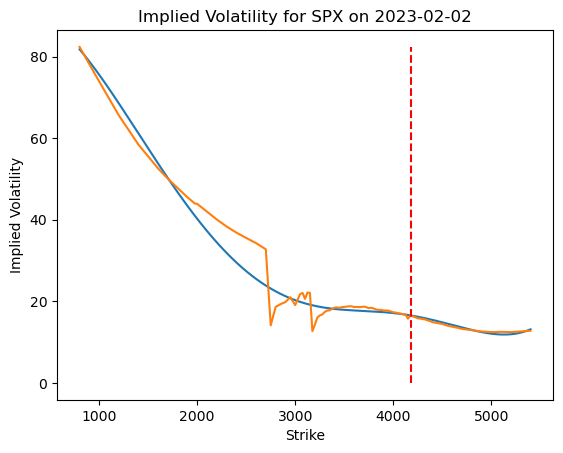

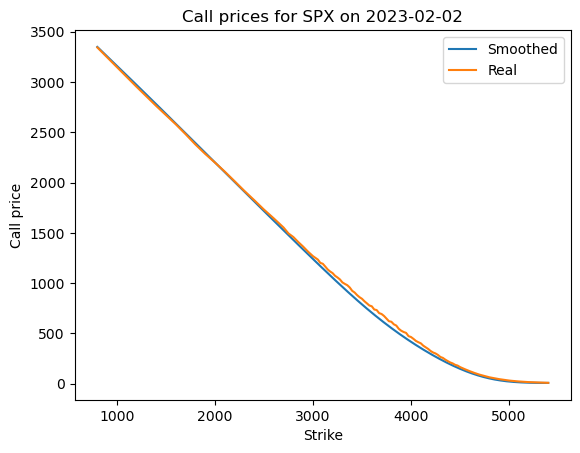

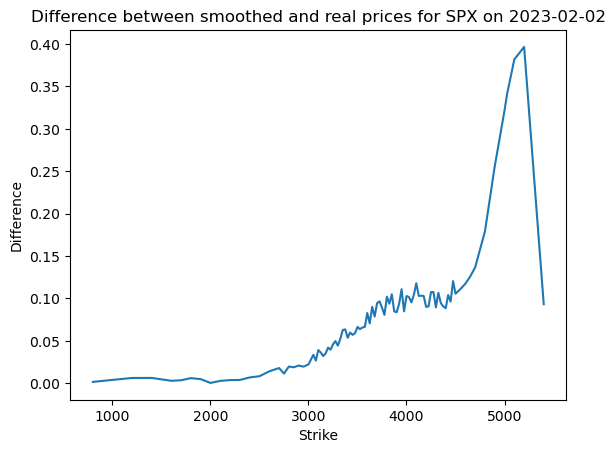

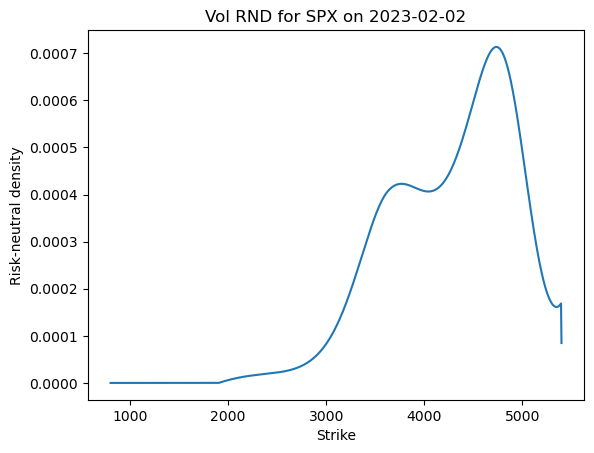

In [55]:
from scipy.interpolate import UnivariateSpline
from scipy.stats import norm

# set weights further from S0 to 0.5
weights = np.ones_like(strikes)
weights[np.abs(strikes - S0) > 1000] = 0.25

# fit spline
vol_spline = UnivariateSpline(strikes, iv, w=weights, k=4)

# plot smoothed vol
plt.plot(strike_range, vol_spline(strike_range), label='spline')
plt.plot(strikes, iv, label='real')    
plt.vlines(S0, 0, max(iv), colors='r', linestyles='dashed')

plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatility for SPX on {quote_date}')
plt.show()


def bs_call(F, K, df, sigma, T):
    d1 = (np.log(F / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return df * (F * norm.cdf(d1) - K * norm.cdf(d2))

smoothvol_calls = bs_call(fwd, strike_range, discount, vol_spline(strike_range)/100, ttm)

bs_strikes = bs_call(fwd, strikes, discount, vol_spline(strikes)/100, ttm)
call_prices = df_expiry['midprice'].values
# plot smoothed prices vs real
plt.plot(strike_range, smoothvol_calls, label='Smoothed')
plt.plot(strikes, call_prices, label='Real')
plt.xlabel('Strike')
plt.ylabel('Call price')
plt.title(f'Call prices for SPX on {quote_date}')
plt.legend()
plt.show()

# plot difference between smoothed price and real price
plt.plot(strikes, np.abs((call_prices - bs_strikes) / call_prices))
plt.xlabel('Strike')
plt.ylabel('Difference')
plt.title(f'Difference between smoothed and real prices for SPX on {quote_date}')
plt.show()

# calc RND
fp = np.gradient(smoothvol_calls)
fpp = np.gradient(fp)
fpp = np.maximum(fpp, 0)

#peak_idx = np.argmax(fpp)
#for i in range(peak_idx - 1, -1, -1):
#    fpp[i] = min(fpp[i], fpp[i+1])
#for i in range(peak_idx + 1, len(fpp)):
#    fpp[i] = min(fpp[i], fpp[i-1])

fpp_area = np.trapz(fpp, strike_range)
vol_rnd = fpp / fpp_area

# plot
plt.plot(strike_range, vol_rnd)
plt.xlabel('Strike')
plt.ylabel('Risk-neutral density')
plt.title(f'Vol RND for SPX on {quote_date}')
plt.show()



Large errors in OTM calls are not too much cause for concern, dont contribute much to the RND

## Comparison

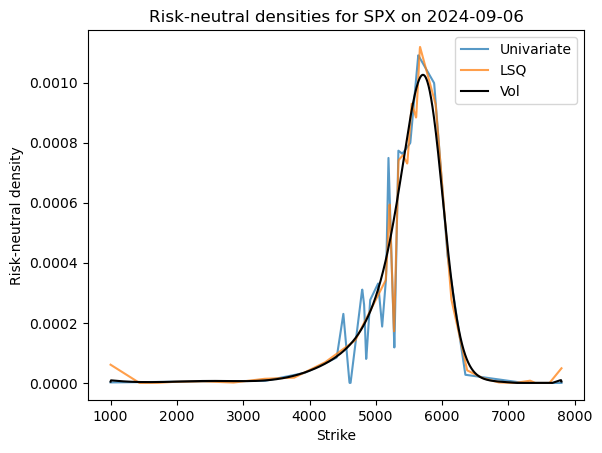

In [69]:
# plot the three RNDs

plt.plot(strike_range, uni_density_normalized, label='Univariate', alpha=0.75)
plt.plot(strike_range, lsq_density_normalized, label='LSQ', alpha=0.75)
plt.plot(strike_range, vol_rnd, label='Vol', color='black')
plt.xlabel('Strike')
plt.ylabel('Risk-neutral density')
plt.title(f'Risk-neutral densities for SPX on {quote_date}')
plt.legend()
plt.show()

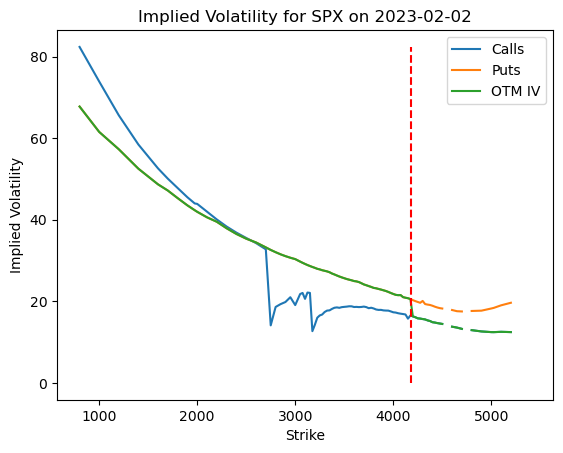

In [ ]:
test_df = df[df['quote'] == quote_date].copy()
test_df.sort_values('strike', inplace=True)
calls = test_df[test_df['option_type'] == 'c']
puts = test_df[test_df['option_type'] == 'p']

calls_otm = puts[puts['strike'] < S0]['Implied Volatility'].values
puts_otm = calls[calls['strike'] > S0]['Implied Volatility'].values
mixed_iv = np.concatenate([calls_otm, puts_otm])

# weighted average of strikes
#cp_strikes = np.concatenate

# plot iv 
plt.plot(calls['strike'], calls['Implied Volatility'], label='Calls')
plt.plot(puts['strike'], puts['Implied Volatility'], label='Puts')
plt.plot(calls['strike'], mixed_iv, label='OTM IV')
plt.vlines(S0, 0, max(iv), colors='r', linestyles='dashed')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatility for SPX on {quote_date}')
plt.legend()
plt.show()